# 2: Tumor Proliferation Analysis

Demonstrate the usage of SpatialCells to analyse tumor cell proliferation, especially using a multivariate proliferation index (MPI) adapted from Gaglia et al. 2022
https://doi.org/10.1038/s41556-022-00860-9

@author: Guihong Wan and Boshen Yan      
@date: Sept 28, 2023        
@last updated: Oct 6, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

import spatialcells as spc

In [2]:
help(spc.msmt.getMPI)

Help on function getMPI in module spatialcells.measurements._getMPI:

getMPI(adata, prolif_markers, arrest_markers, thresh_prolif=0.5, thresh_arrest=0.5, use_obs=False, use_layer=None, col_name='MPI', inplace=True)
    Get MPI from a list of markers and thresholds, adapted from Gaglia et al. 2022
    https://doi.org/10.1038/s41556-022-00860-9
    MPI = :
     -1 if max(arrest_markers) > thresh_arrest
      1 else if max(prolif_markers) > thresh_prolif
      0 otherwise
    
    :param adata: AnnData object
    :param prolif_marker: List of proliferation markers
    :param arrest_markers: List of arrest markers
    :param thresh_prolif: Threshold for proliferation. Default is 0.5
    :param thresh_arrest: Threshold for arrest, which should be set
        based on the expression levels of KI67 marker. Default is 0.5
    :param use_obs: If True, use adata.obs[use_obs] to get the markers.
        Overrides use_layer. If use_obs==False and use_layer is None, use adata.X
    :param use_layer

In [3]:
# load and preprocess the normalized dataset for MPI calculation
adata1 = ad.read("../../../Cycif/Z147_1_750.h5ad")
spc.prep.setGate(adata1, "SOX10", 0.5, debug=True)

spc.msmt.getMPI(
    adata1,
    prolif_markers=["KI67"],
    arrest_markers=[],
    thresh_prolif=0.60,
    thresh_arrest=0.5,
    use_layer=None,
    col_name="MPI",
    inplace=True,
)
adata1.obs["MPI"].value_counts()
MPI_df1 = adata1.obs["MPI"].to_numpy()
print(f"\nSlide-level mean MPI for all SOX10+ cells: {MPI_df1.sum() / len(MPI_df1)}")

print("\nSOX10+ cells MPI counts:")
adata1[(adata1[:, "SOX10"].X > 0.5)].obs["MPI"].value_counts()

SOX10_positive
False    586292
True     524293
Name: count, dtype: int64
No arrest markers found. Skipping.

Slide-level mean MPI for all SOX10+ cells: 0.07579248774294628

SOX10+ cells MPI counts:


MPI
0.0    486488
1.0     37804
Name: count, dtype: int64

In [4]:
# transfer the MPI values to the original dataset
adata = ad.read("../../../Cycif/unmicst-1_750_PCA_Mel1.h5ad")
spc.prep.setGate(adata, "KERATIN_cellRingMask", 6.4, debug=True)
spc.prep.setGate(adata, "CD3D_cellRingMask", 7.2, debug=True)
spc.prep.setGate(adata, "KI67_cellRingMask", 6.7, debug=True)
spc.prep.setGate(adata, "PCNA_cellRingMask", 7.3, debug=True)
adata.obs["MPI_KI67"] = MPI_df1

KERATIN_cellRingMask_positive
False    1067400
True       43185
Name: count, dtype: int64
CD3D_cellRingMask_positive
False    1061480
True       49105
Name: count, dtype: int64
KI67_cellRingMask_positive
False    1025315
True       85270
Name: count, dtype: int64
PCNA_cellRingMask_positive
False    896678
True     213907
Name: count, dtype: int64


#### After calculating MPI for all tumor cells, we isolate tumor cell communities and draw an extended region of interest boundary, before doing a sliding window composition analysis to understand the spatial distribution of proliferating tumor cells

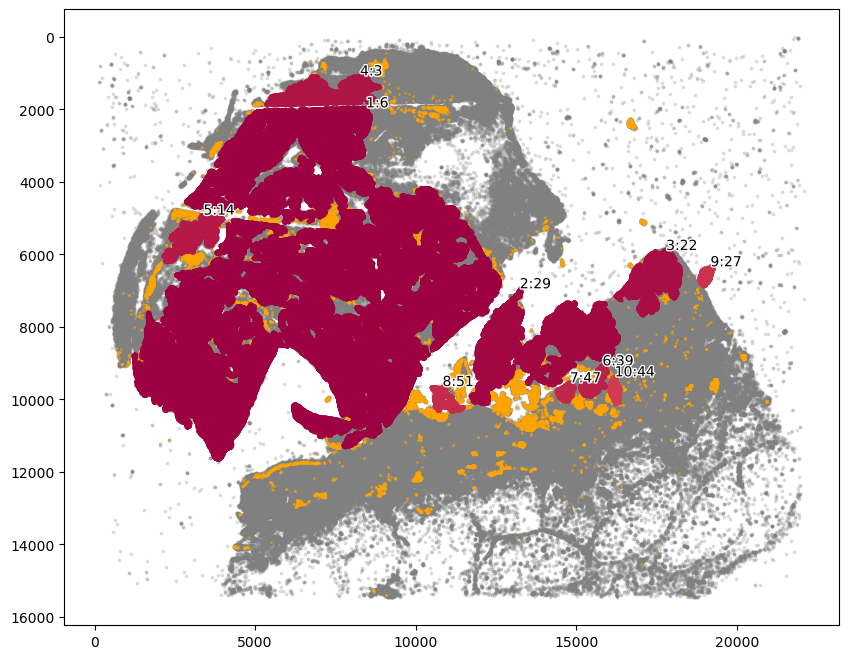

In [5]:
marker = ["SOX10_positive"]
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, marker, eps=60, newcolumn=communitycolumn)
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=2, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

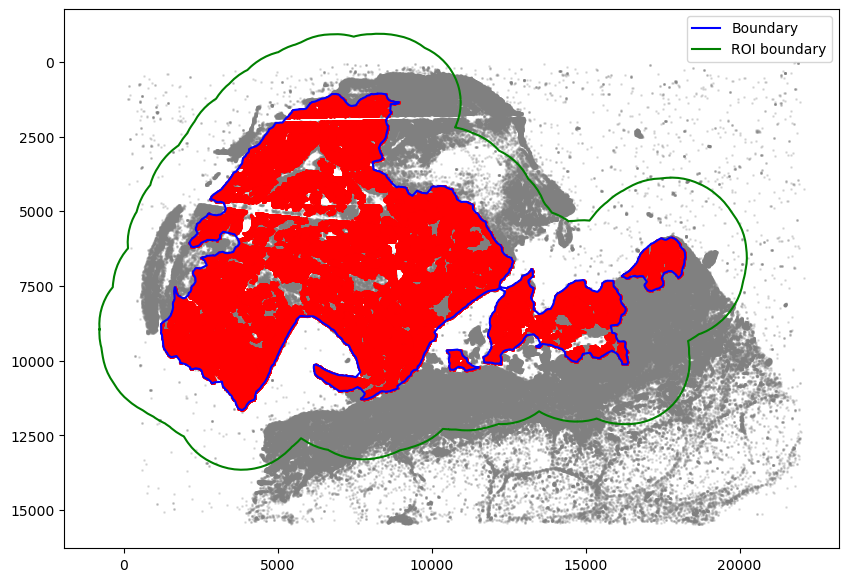

In [6]:
communityIndexList = [6, 3, 14, 51, 29, 47, 39, 44, 22]
boundary = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=130
)
boundary = spc.spa.pruneSmallComponents(boundary, min_edges=50, holes_min_edges=500)
roi_boundary = spc.spa.getExtendedBoundary(boundary, offset=2000)
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="b")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")

ax.invert_yaxis()
plt.legend(loc="upper right")
plt.show()

### Assign cells to tumor region

1094867it [00:30, 36148.23it/s]


Assigned points to region: Tumor_ROI


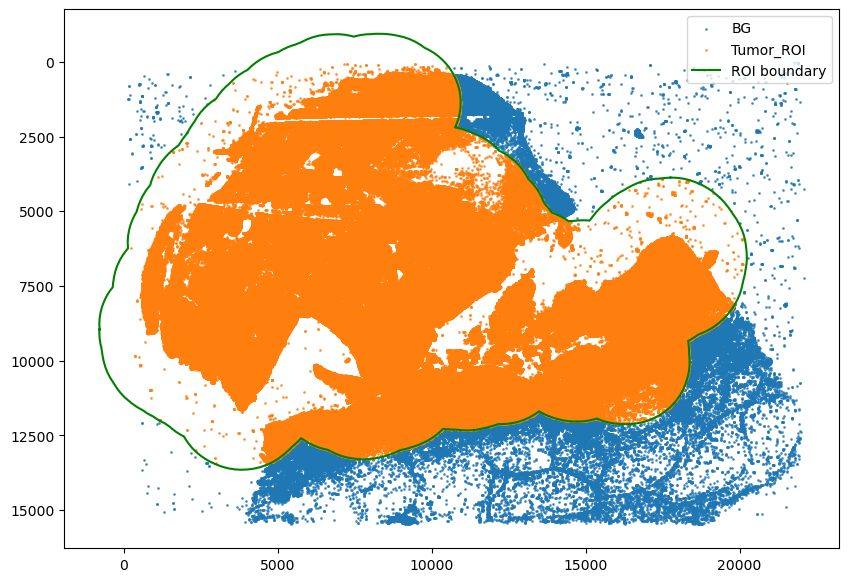

In [7]:
spc.spatial.assignPointsToRegions(
    adata, [roi_boundary], ["Tumor_ROI"], assigncolumn="region", default="BG"
)
point_size = 1
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.7,
        label=region
    )
# Bounds of points in selected commnities
# spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="b")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")

plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

In [8]:
spc.msmt.getRegionComposition(
    adata, ["SOX10_positive", "MPI_KI67"], regions="Tumor_ROI"
)

,SOX10_positive,MPI_KI67,cell_count,composition
0,True,0.0,503266,0.92677
1,False,0.0,440660,0.91053
2,False,1.0,43300,0.08947
3,True,1.0,39766,0.07323


In [9]:
size = 300
adata1 = adata[adata.obs["SOX10_positive"]]
print(adata1.obs.shape)
prolif_df_ki67 = spc.msmt.getSlidingWindowsComposition(
    adata1,
    size,
    size,
    "MPI_KI67",
    # region_col="region",
    region_subset=["Tumor_ROI"],
    min_cells=50,
)
prolif_df_ki67.head()

(544009, 27)


,MPI_KI67,cell_count,composition,X_start,Y_start,window_size,step_size
0,0.0,62,0.826667,966,8849,300,300
1,1.0,13,0.173333,966,8849,300,300
0,0.0,53,1.000000,1266,8249,300,300
0,0.0,260,0.996169,1266,8549,300,300
1,1.0,1,0.003831,1266,8549,300,300


In [10]:
def threshold_my_cmap(cmap, threshold, val=0):
    from matplotlib.colors import ListedColormap
    import matplotlib

    colormap = matplotlib.colormaps[cmap]
    newcolors = colormap(np.linspace(0, 1, 256))
    color = np.array([val, val, val, 1])
    newcolors[:threshold, :] = color
    newcmp = ListedColormap(newcolors)
    return newcmp


myGreens = threshold_my_cmap("Greens", 2, 1)
myReds = threshold_my_cmap("Reds", 2, 1)

mask = spc.msmt.get_comp_mask(prolif_df_ki67, "MPI_KI67", [1.0], size)

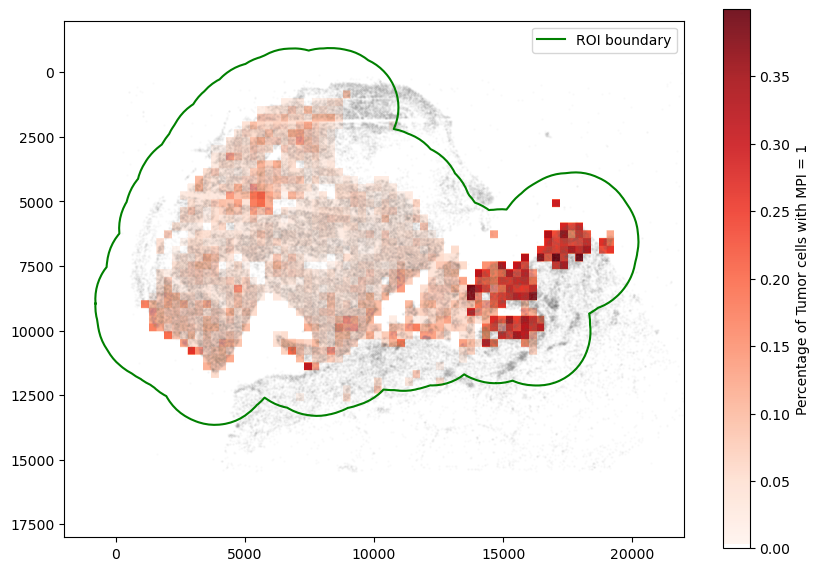

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.imshow(mask, alpha=0.9, cmap=myReds, extent=(0, 1, 0, 1))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Percentage of Tumor cells with MPI = 1")
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region].sample(frac=0.1)
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=1,
        alpha=0.02,
        color="grey"
    )

spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")
ax.imshow(mask, alpha=1, cmap=myReds)
plt.legend(loc="upper right", markerscale=10)
ax.invert_yaxis()
ax.set_ylim(18000, -2000)
ax.set_xlim(-2000, 22000)
# plt.savefig("MPI_KI67_ROI.png", dpi=300)
plt.show()

<Axes: xlabel='MPI_KI67', ylabel='composition'>

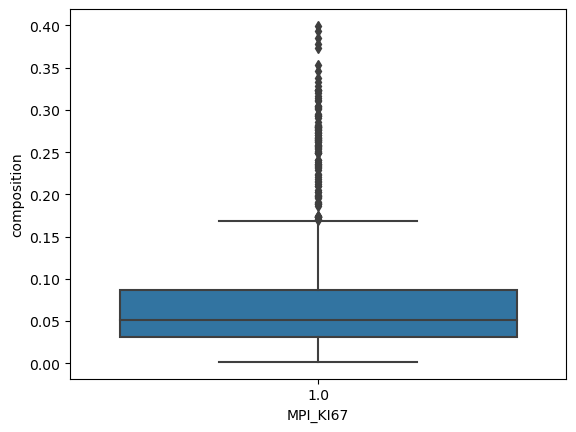

In [12]:
sns.boxplot(
    data=prolif_df_ki67[prolif_df_ki67["MPI_KI67"] == 1],
    x="MPI_KI67",
    y="composition",
)

#### We can also look at the distance of each window from the epidermis, to capture if the tumor is undergoing horizontal or vertical growth

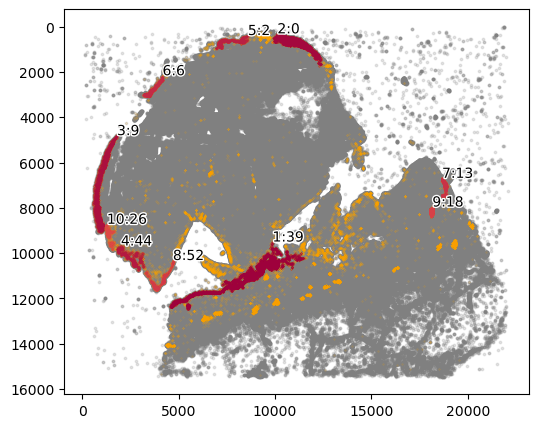

In [13]:
# adata.obs["keratinocytes"] = adata.obs["phenotype_large_cohort"].isin(["Keratinocytes"])
marker = ["KERATIN_cellRingMask_positive"]
communitycolumn = "epi_community"
ret = spc.spatial.getCommunities(adata, marker, eps=100, newcolumn=communitycolumn)
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(6, 5))
spc.plt.plotCommunities(
    adata,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=0.1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

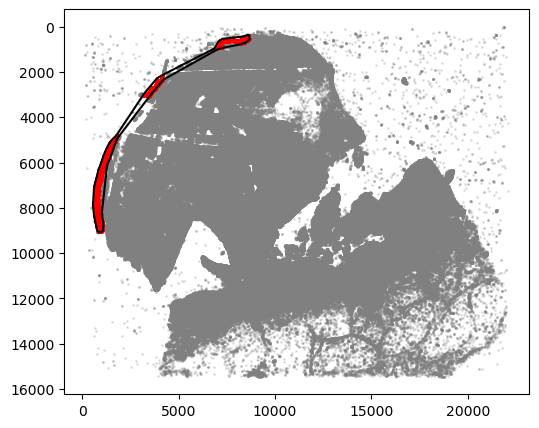

In [14]:
communityIndexList = [2, 6, 9]
epi_boundary = spc.spa.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=3000
)
markersize = 1
fig, ax = plt.subplots(figsize=(6, 5))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
spc.plt.plotBoundary(epi_boundary, ax=ax, linewidth=1.5, color="k")
ax.invert_yaxis()
plt.show()

In [15]:
prolif_df_ki67["x"] = prolif_df_ki67["X_start"] + prolif_df_ki67["window_size"] / 2
prolif_df_ki67["y"] = prolif_df_ki67["Y_start"] + prolif_df_ki67["window_size"] / 2
# prolif_xy = prolif_df_ki67[["x", "y"]].to_numpy()
prolif_adata = ad.AnnData(obs=prolif_df_ki67)
spc.msmt.getDistanceFromObject(
    prolif_adata, epi_boundary, x="x", y="y", region_col="MPI_KI67", region_subset=[1.0]
)

/Users/boshenyan/anaconda3/envs/spatial-cells/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/boshenyan/anaconda3/envs/spatial-cells/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
995it [00:00, 87122.30it/s]


In [16]:
prolif_adata.obs

,MPI_KI67,cell_count,composition,X_start,Y_start,window_size,step_size,x,y,distance
0,0.0,62,0.826667,966,8849,300,300,1116.0,8999.0,NaN
1,1.0,13,0.173333,966,8849,300,300,1116.0,8999.0,53.498597
0,0.0,53,1.000000,1266,8249,300,300,1416.0,8399.0,NaN
0,0.0,260,0.996169,1266,8549,300,300,1416.0,8699.0,NaN
1,1.0,1,0.003831,1266,8549,300,300,1416.0,8699.0,321.845776
...,...,...,...,...,...,...,...,...,...,...
1,1.0,28,0.122807,18966,6149,300,300,19116.0,6299.0,11913.575943
0,0.0,646,0.800496,18966,6449,300,300,19116.0,6599.0,NaN
1,1.0,161,0.199504,18966,6449,300,300,19116.0,6599.0,12061.068139
0,0.0,72,0.742268,18966,6749,300,300,19116.0,6899.0,NaN


Text(0.5, 0, 'Distance to epidermis / um')

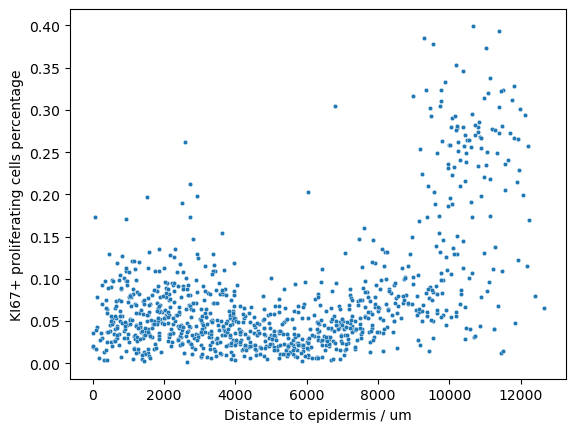

In [17]:
sns.scatterplot(
    data=prolif_adata.obs[prolif_adata.obs["MPI_KI67"] == 1.0],
    x="distance",
    y="composition",
    s=10,
)
plt.ylabel("KI67+ proliferating cells percentage")
plt.xlabel("Distance to epidermis / um")